# Indices

### 95%

In [ ]:
# COMPLETE WORKING LIGHT THEME VIOLIN PLOT CODE
# This includes all necessary imports and data preparation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
from sklearn.neighbors import KernelDensity

# Define class mapping
CLASS_MAPPING = {
    0: 'Water',
    1: 'Sand',
    2: 'Rock',
    3: 'Algae',
    4: 'NPV',
    5: 'PV'
}

def load_data(raster_path, shapefile_path):
    """Load the multispectral raster and validation points"""
    print(f"Attempting to load shapefile from: {shapefile_path}")
    with rasterio.open(raster_path) as src:
        data = src.read()
        transform = src.transform
        print(f"Raster loaded with shape: {data.shape}")
        
    points = gpd.read_file(shapefile_path)
    print("Available columns in shapefile:")
    print(points.columns)
    print("\nSample of points data:")
    print(points.head())
    
    return data, transform, points

def extract_pixel_values(data, points, transform):
    """Extract pixel values at validation point locations"""
    rows, cols = rasterio.transform.rowcol(transform, 
                                         points.geometry.x, 
                                         points.geometry.y)
    
    pixel_values = pd.DataFrame()
    pixel_values['green'] = data[0, rows, cols]     # b1
    pixel_values['red'] = data[1, rows, cols]       # b2
    pixel_values['red_edge'] = data[2, rows, cols]  # b3
    pixel_values['nir'] = data[3, rows, cols]       # b4
    
    pixel_values['class'] = points['Class'].map(CLASS_MAPPING)
    
    return pixel_values

def calculate_indices(df):
    """Calculate all vegetation indices"""
    indices = pd.DataFrame()
    
    # NDVI = (NIR - Red)/(NIR + Red)
    indices['NDVI'] = (df['nir'] - df['red']) / (df['nir'] + df['red'])
    
    # NDWI = (Green - NIR)/(Green + NIR)
    indices['NDWI'] = (df['green'] - df['nir']) / (df['green'] + df['nir'])
    
    # NDRE = (NIR - RedEdge)/(NIR + RedEdge)
    indices['NDRE'] = (df['nir'] - df['red_edge']) / (df['nir'] + df['red_edge'])
    
    # SR = NIR/Red
    indices['SR'] = df['nir'] / df['red']
    
    # DVI = NIR - Red
    indices['DVI'] = df['nir'] - df['red']
    
    # SAVI = ((NIR - Red)(1 + L))/(NIR + Red + L) where L = 0.25
    L = 0.25
    indices['SAVI'] = ((df['nir'] - df['red']) * (1 + L)) / (df['nir'] + df['red'] + L)
    
    # OSAVI = (NIR - Red)/(NIR + Red + 0.16)
    indices['OSAVI'] = (df['nir'] - df['red']) / (df['nir'] + df['red'] + 0.16)
    
    # EVI2 = 2.5 * (NIR - Red)/(NIR + 2.4*Red + 1)
    indices['EVI2'] = 2.5 * (df['nir'] - df['red']) / (df['nir'] + 2.4*df['red'] + 1)
    
    # CMRI = NDVI - NDWI
    indices['CMRI'] = indices['NDVI'] - indices['NDWI']
    
    # SDVC = (Green - RedEdge)/(Green + RedEdge)
    indices['SDVC'] = (df['green'] - df['red_edge']) / (df['green'] + df['red_edge'])
    
    # NRER = (NIR - RedEdge)/(NIR + RedEdge + Red)
    indices['NRER'] = (df['nir'] - df['red_edge']) / (df['nir'] + df['red_edge'] + df['red'])
    
    # WMCI = NRER - EVI2
    indices['WMCI'] = indices['NRER'] - indices['EVI2']
    
    return indices

def analyze_class_ranges_and_overlaps(indices, true_classes):
    """
    For each vegetation index:
    1. Calculate 95% value range for PV and NPV
    2. Identify which classes overlap most with these ranges (top 3)
    """
    results = []
    
    print("Available classes in data:", true_classes.unique())
    
    for column in indices.columns:
        # Get values for PV and NPV
        pv_vals = indices[column][true_classes == 'PV']
        npv_vals = indices[column][true_classes == 'NPV']
        
        # Calculate 95% ranges
        pv_range = np.percentile(pv_vals, [2.5, 97.5])
        npv_range = np.percentile(npv_vals, [2.5, 97.5])
        
        # Initialize overlap tracking
        pv_overlaps = {}
        npv_overlaps = {}
        
        # Calculate overlap percentages for other classes
        for class_name in true_classes.unique():
            if class_name != 'PV':
                class_vals = indices[column][true_classes == class_name]
                if len(class_vals) > 0:
                    pv_overlap = 100 * np.mean((class_vals >= pv_range[0]) & 
                                             (class_vals <= pv_range[1]))
                    pv_overlaps[class_name] = pv_overlap
            
            if class_name != 'NPV':
                class_vals = indices[column][true_classes == class_name]
                if len(class_vals) > 0:
                    npv_overlap = 100 * np.mean((class_vals >= npv_range[0]) & 
                                              (class_vals <= npv_range[1]))
                    npv_overlaps[class_name] = npv_overlap
        
        # Sort overlaps to find top overlapping classes
        pv_top_overlaps = sorted(pv_overlaps.items(), 
                               key=lambda x: x[1], 
                               reverse=True)[:3]
        npv_top_overlaps = sorted(npv_overlaps.items(), 
                                key=lambda x: x[1], 
                                reverse=True)[:3]
        
        results.append({
            'Index': column,
            'PV 95% Range': f"({pv_range[0]:.3f}, {pv_range[1]:.3f})",
            'Top PV Overlaps': (f"{pv_top_overlaps[0][0]} ({pv_top_overlaps[0][1]:.1f}%), "
                              f"{pv_top_overlaps[1][0]} ({pv_top_overlaps[1][1]:.1f}%), "
                              f"{pv_top_overlaps[2][0]} ({pv_top_overlaps[2][1]:.1f}%)"),
            'NPV 95% Range': f"({npv_range[0]:.3f}, {npv_range[1]:.3f})",
            'Top NPV Overlaps': (f"{npv_top_overlaps[0][0]} ({npv_top_overlaps[0][1]:.1f}%), "
                               f"{npv_top_overlaps[1][0]} ({npv_top_overlaps[1][1]:.1f}%), "
                               f"{npv_top_overlaps[2][0]} ({npv_top_overlaps[2][1]:.1f}%)")
        })
    
    # Convert to DataFrame and set display options for better formatting
    df = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)
    
    return df

def plot_class_overlaps(indices, true_classes, 
                    figsize=(16, None), 
                    font_family='Arial',
                    title_fontsize=12,
                    xlabel_fontsize=16,
                    ylabel_fontsize=18,
                    tick_fontsize=14,
                    legend_fontsize=12,
                    save_path=None,
                    w_pad=0.5,
                    wspace=0.2
                    ):
    """
    Create violin plots showing distribution overlaps and 95% ranges - LIGHT THEME
    """
    # Reset to default matplotlib style (light theme)
    plt.style.use('default')
    
    # Calculate figure height if not provided
    n_indices = len(indices.columns)
    n_rows = (n_indices + 2) // 3
    
    if figsize[1] is None:
        figsize = (figsize[0], 6.5*n_rows + 1.5)
    
    # Create figure with light background
    fig = plt.figure(figsize=figsize, facecolor='white')
    plt.rcParams['font.family'] = font_family
    
    # Create grid with space for legend
    gs = fig.add_gridspec(n_rows + 1, 3, height_ratios=[1]*n_rows + [0.2])
    
    # Create axes with shared y
    axes = []
    for row in range(n_rows):
        for col in range(3):
            if row * 3 + col < n_indices:
                if row * 3 + col == 0:
                    ax = fig.add_subplot(gs[row, col])
                    ax.set_facecolor('white')
                    first_ax = ax
                else:
                    ax = fig.add_subplot(gs[row, col], sharey=first_ax)
                    ax.set_facecolor('white')
                axes.append(ax)
    
    axes = np.array(axes)
    
    # Original light theme color palette
    class_colors = {
        'PV': '#228833',
        'NPV': '#EE7733',
        'Water': '#0077BB',
        'Sand': '#CCBB44',
        'Rock': '#BBBBBB',
        'Algae': '#AA3377'
    }
    
    class_order = ['PV', 'NPV', 'Water', 'Sand', 'Rock', 'Algae']
    
    # Store handles for legend
    legend_handles = []
    
    for idx, index_name in enumerate(indices.columns):
        if idx < len(axes):
            # Create data for this specific index
            plot_data = pd.DataFrame({
                'values': indices[index_name],
                'class': true_classes  # Use true_classes directly
            })
            
            # Create violin plot
            vplot = sns.violinplot(data=plot_data, x='values', y='class', 
                                 order=class_order, orient='h', ax=axes[idx],
                                 inner='quartile')
            
            # Manually set colors
            for i, class_name in enumerate(class_order):
                if i < len(axes[idx].collections):
                    axes[idx].collections[i].set_facecolor(class_colors[class_name])
                    axes[idx].collections[i].set_edgecolor('black')
                    axes[idx].collections[i].set_alpha(0.8)
            
            # Style axes for light theme
            axes[idx].tick_params(axis='both', which='major', colors='black')
            axes[idx].spines['bottom'].set_color('black')
            axes[idx].spines['top'].set_color('black')
            axes[idx].spines['right'].set_color('black')
            axes[idx].spines['left'].set_color('black')
            
            # Calculate 95% ranges
            pv_data = plot_data[plot_data['class'] == 'PV']['values']
            npv_data = plot_data[plot_data['class'] == 'NPV']['values']
            
            if len(pv_data) > 0 and len(npv_data) > 0:
                pv_range = np.percentile(pv_data, [2.5, 97.5])
                npv_range = np.percentile(npv_data, [2.5, 97.5])
                
                # Add range indicators
                axes[idx].axvspan(pv_range[0], pv_range[1], alpha=0.2, color='green')
                axes[idx].axvspan(npv_range[0], npv_range[1], alpha=0.2, color='orange')
            
            # Customize plot
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(axis='x', labelsize=tick_fontsize-2, colors='black')
            axes[idx].tick_params(axis='y', labelsize=tick_fontsize-2, colors='black')
            axes[idx].set_xlabel(index_name, fontsize=xlabel_fontsize-2, color='black')
            
            # Hide y-axis labels for non-first column plots
            if idx % 3 != 0:
                for label in axes[idx].get_yticklabels():
                    label.set_visible(False)
                axes[idx].set_ylabel('')
            else:
                axes[idx].set_ylabel('Class', fontsize=ylabel_fontsize-2, color='black')
            
            # Store handles for first plot
            if idx == 0:
                handles = []
                for class_name in class_order:
                    handles.append(plt.Rectangle((0,0), 1, 1, fc=class_colors[class_name]))
                legend_handles.extend(handles)
                
                legend_handles.extend([
                    plt.Rectangle((0,0), 1, 1, fc='green', alpha=0.2),
                    plt.Rectangle((0,0), 1, 1, fc='orange', alpha=0.2)
                ])
    
    # Remove any extra subplots
    for idx in range(n_indices, len(axes)):
        fig.delaxes(axes[idx])
    
    # Add legend
    legend_ax = fig.add_subplot(gs[-1, :])
    legend_ax.axis('off')
    legend_ax.set_facecolor('white')
    
    legend_labels = ['PV 95% range', 'NPV 95% range']
    legend = axes[0].legend(legend_handles[6:], legend_labels,
                        loc='upper left', 
                        ncol=1,
                        bbox_to_anchor=(0, 1),
                        fontsize=legend_fontsize,
                        facecolor='white',
                        edgecolor='black')
    
    plt.tight_layout(w_pad=w_pad)
    plt.subplots_adjust(wspace=wspace)
    
    # Save figure if path is provided
    if save_path:
        fig.savefig(save_path, dpi=900, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    return fig, axes

def main():
    # File paths
    raster_path = '20240424_GoldRockCreek_Multi+Indices.tif'
    shapefile_path = 'MangroveValidationPoints.shp'
    
    # Load and process data
    data, transform, points = load_data(raster_path, shapefile_path)
    pixel_values = extract_pixel_values(data, points, transform)
    indices = calculate_indices(pixel_values)
    
    # Analyze class ranges and overlaps
    print("\nAnalyzing class ranges and overlaps...")
    overlap_table = analyze_class_ranges_and_overlaps(indices, pixel_values['class'])
    print("\nIndex Range Analysis and Class Overlaps:")
    print(overlap_table.to_string())
    
    # Create light theme violin plots
    fig, axes = plot_class_overlaps(
        indices, 
        pixel_values['class'], 
        figsize=(14, 16),
        save_path='IndexRange_ViolinPlots_LightTheme.jpg',
        w_pad=0.12,
        wspace=0.05
    )
    
    plt.show()

if __name__ == "__main__":
    main()

### Optimal

Attempting to load shapefile from: MangroveValidationPoints.shp
Raster loaded with shape: (7, 9000, 12219)
Available columns in shapefile:
Index(['fid', 'Class', 'geometry'], dtype='object')

Sample of points data:
   fid  Class                    geometry
0  2.0      1  POINT (-78.39213 26.60454)
1  3.0      1  POINT (-78.39204 26.60455)
2  4.0      1   POINT (-78.3921 26.60459)
3  5.0      1    POINT (-78.392 26.60456)
4  6.0      1  POINT (-78.39209 26.60455)

Analyzing mangrove value distributions...

Analysis results saved to: mangrove_distribution_analysis.csv

Mangrove Distribution Analysis:
    Index  NPV Peak         NPV Range  NPV Coverage                                                         NPV Overlaps   PV Peak          PV Range  PV Coverage                                                          PV Overlaps
0    NDVI  0.163153    (0.033, 0.294)          75.0   Rock (54.9%), Sand (33.6%), Algae (26.7%), Water (0.2%), PV (0.1%)  0.815184    (0.755, 0.876)         73.2  

C:\Users\Tom Ingalls\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tom Ingalls\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Tom Ingalls\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Tom Ingalls\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

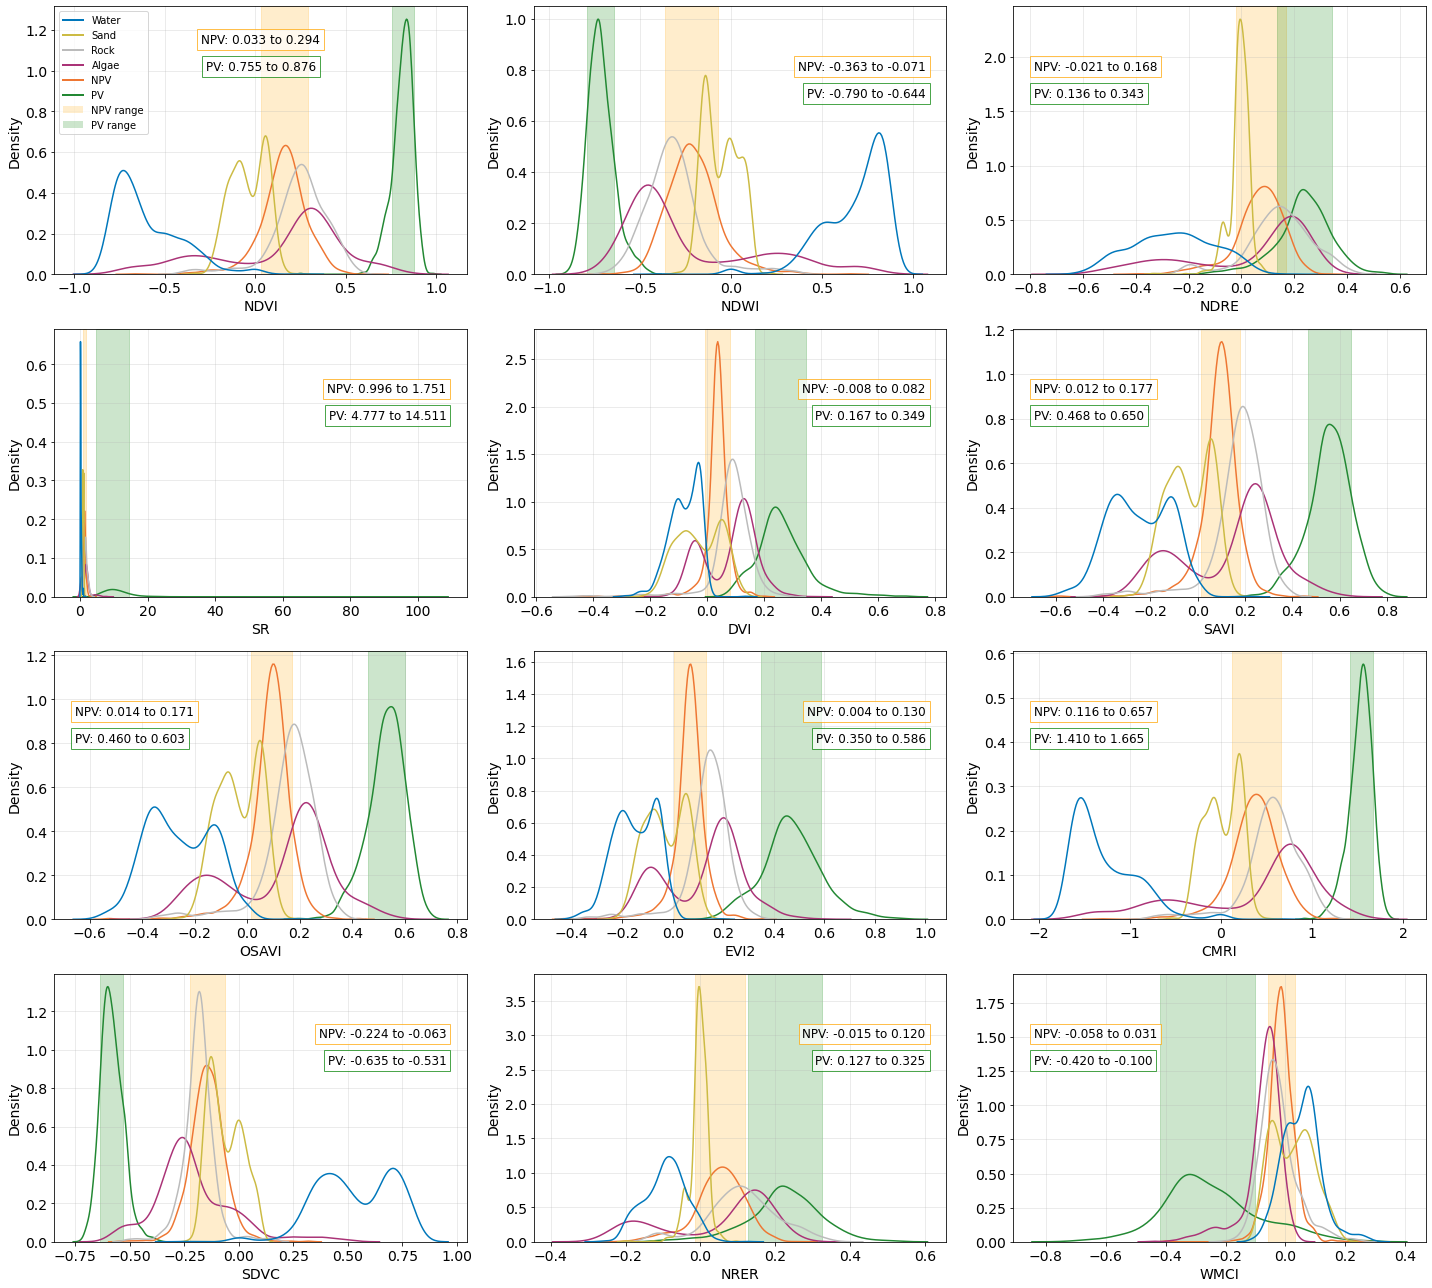

In [1]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

# Define class mapping
CLASS_MAPPING = {
    0: 'Water',
    1: 'Sand',
    2: 'Rock',
    3: 'Algae',
    4: 'NPV',
    5: 'PV'
}

def load_data(raster_path, shapefile_path):
    """Load the multispectral raster and validation points"""
    print(f"Attempting to load shapefile from: {shapefile_path}")
    with rasterio.open(raster_path) as src:
        data = src.read()
        transform = src.transform
        print(f"Raster loaded with shape: {data.shape}")
        
    points = gpd.read_file(shapefile_path)
    print("Available columns in shapefile:")
    print(points.columns)
    print("\nSample of points data:")
    print(points.head())
    
    return data, transform, points

def extract_pixel_values(data, points, transform):
    """Extract pixel values at validation point locations"""
    rows, cols = rasterio.transform.rowcol(transform, 
                                         points.geometry.x, 
                                         points.geometry.y)
    
    pixel_values = pd.DataFrame()
    pixel_values['green'] = data[0, rows, cols]     # b1
    pixel_values['red'] = data[1, rows, cols]       # b2
    pixel_values['red_edge'] = data[2, rows, cols]  # b3
    pixel_values['nir'] = data[3, rows, cols]       # b4
    
    pixel_values['class'] = points['Class'].map(CLASS_MAPPING)
    
    return pixel_values

def calculate_indices(df):
    """Calculate all vegetation indices"""
    indices = pd.DataFrame()
    
    # NDVI = (NIR - Red)/(NIR + Red)
    indices['NDVI'] = (df['nir'] - df['red']) / (df['nir'] + df['red'])
    
    # NDWI = (Green - NIR)/(Green + NIR)
    indices['NDWI'] = (df['green'] - df['nir']) / (df['green'] + df['nir'])
    
    # NDRE = (NIR - RedEdge)/(NIR + RedEdge)
    indices['NDRE'] = (df['nir'] - df['red_edge']) / (df['nir'] + df['red_edge'])
    
    # SR = NIR/Red
    indices['SR'] = df['nir'] / df['red']
    
    # DVI = NIR - Red
    indices['DVI'] = df['nir'] - df['red']
    
    # SAVI = ((NIR - Red)(1 + L))/(NIR + Red + L) where L = 0.25
    L = 0.25
    indices['SAVI'] = ((df['nir'] - df['red']) * (1 + L)) / (df['nir'] + df['red'] + L)
    
    # OSAVI = (NIR - Red)/(NIR + Red + 0.16)
    indices['OSAVI'] = (df['nir'] - df['red']) / (df['nir'] + df['red'] + 0.16)
    
    # EVI2 = 2.5 * (NIR - Red)/(NIR + 2.4*Red + 1)
    indices['EVI2'] = 2.5 * (df['nir'] - df['red']) / (df['nir'] + 2.4*df['red'] + 1)
    
    # CMRI = NDVI - NDWI
    indices['CMRI'] = indices['NDVI'] - indices['NDWI']
    
    # SDVC = (Green - RedEdge)/(Green + RedEdge)
    indices['SDVC'] = (df['green'] - df['red_edge']) / (df['green'] + df['red_edge'])
    
    # NRER = (NIR - RedEdge)/(NIR + RedEdge + Red)
    indices['NRER'] = (df['nir'] - df['red_edge']) / (df['nir'] + df['red_edge'] + df['red'])
    
    # WMCI = NRER - EVI2
    indices['WMCI'] = indices['NRER'] - indices['EVI2']
    
    return indices

def analyze_mangrove_distributions(indices, true_classes):
    """
    Analyze the distribution of both NPV and PV mangrove values for each index
    and suggest ranges centered on their peaks
    """
    results = []
    
    for column in indices.columns:
        # Get values for NPV and PV mangrove
        npv_vals = indices[column][true_classes == 'NPV']
        pv_vals = indices[column][true_classes == 'PV']
        
        # Calculate statistics for NPV
        npv_mean = np.mean(npv_vals)
        npv_std = np.std(npv_vals)
        
        # Calculate statistics for PV
        pv_mean = np.mean(pv_vals)
        pv_std = np.std(pv_vals)
        
        # Get the peak for NPV using kernel density estimation
        kde_npv = KernelDensity(bandwidth='scott')
        kde_npv.fit(npv_vals.values.reshape(-1, 1))
        
        # Find the NPV peak
        x_test_npv = np.linspace(npv_mean - 3*npv_std, npv_mean + 3*npv_std, 1000).reshape(-1, 1)
        kde_scores_npv = kde_npv.score_samples(x_test_npv)
        npv_peak_idx = np.argmax(kde_scores_npv)
        npv_peak_value = x_test_npv[npv_peak_idx][0]
        
        # Get the peak for PV using kernel density estimation
        kde_pv = KernelDensity(bandwidth='scott')
        kde_pv.fit(pv_vals.values.reshape(-1, 1))
        
        # Find the PV peak
        x_test_pv = np.linspace(pv_mean - 3*pv_std, pv_mean + 3*pv_std, 1000).reshape(-1, 1)
        kde_scores_pv = kde_pv.score_samples(x_test_pv)
        pv_peak_idx = np.argmax(kde_scores_pv)
        pv_peak_value = x_test_pv[pv_peak_idx][0]
        
        # Calculate suggested ranges around peaks
        npv_range = (npv_peak_value - npv_std, npv_peak_value + npv_std)
        pv_range = (pv_peak_value - pv_std, pv_peak_value + pv_std)
        
        # Calculate overlap percentages for NPV range
        npv_overlaps = {}
        for class_name in true_classes.unique():
            class_vals = indices[column][true_classes == class_name]
            overlap = np.mean((class_vals >= npv_range[0]) & 
                            (class_vals <= npv_range[1])) * 100
            npv_overlaps[class_name] = overlap
            
        # Calculate overlap percentages for PV range
        pv_overlaps = {}
        for class_name in true_classes.unique():
            class_vals = indices[column][true_classes == class_name]
            overlap = np.mean((class_vals >= pv_range[0]) & 
                            (class_vals <= pv_range[1])) * 100
            pv_overlaps[class_name] = overlap
        
        results.append({
            'Index': column,
            'NPV Peak': npv_peak_value,
            'NPV Range': f"({npv_range[0]:.3f}, {npv_range[1]:.3f})",
            'NPV Coverage': npv_overlaps['NPV'],
            'NPV Overlaps': ', '.join([f"{k} ({v:.1f}%)" 
                                      for k, v in sorted(npv_overlaps.items(), key=lambda x: x[1], reverse=True)
                                      if k != 'NPV']),
            'PV Peak': pv_peak_value,
            'PV Range': f"({pv_range[0]:.3f}, {pv_range[1]:.3f})",
            'PV Coverage': pv_overlaps['PV'],
            'PV Overlaps': ', '.join([f"{k} ({v:.1f}%)" 
                                    for k, v in sorted(pv_overlaps.items(), key=lambda x: x[1], reverse=True)
                                    if k != 'PV'])
        })
    
    return pd.DataFrame(results)

def plot_index_distributions(indices, true_classes, mangrove_analysis):
    """
    Create comprehensive distribution plots showing class separations
    with ranges centered on both NPV and PV mangrove peaks, 
    with range information displayed in appropriate corners
    """
    n_indices = len(indices.columns)
    n_rows = (n_indices + 2) // 3
    
    # Create figure with reduced height
    fig = plt.figure(figsize=(20, 4.5*n_rows))
    gs = fig.add_gridspec(n_rows, 3)
    
    # Create axes for plots
    axes = []
    for row in range(n_rows):
        for col in range(3):
            if row * 3 + col < n_indices:
                ax = fig.add_subplot(gs[row, col])
                axes.append(ax)
    
    # Color scheme
    class_colors = {
        'Water': '#0077BB',
        'Sand': '#CCBB44',
        'Rock': '#BBBBBB',
        'Algae': '#AA3377',
        'NPV': '#EE7733',
        'PV': '#228833'
    }
    
    # Create legend handles for later use in the first subplot
    handles = []
    labels = []
    
    # Class colors
    for class_name, color in class_colors.items():
        handles.append(plt.Line2D([0], [0], color=color, lw=2))
        labels.append(class_name)
    
    # Range patches
    handles.extend([
        plt.Rectangle((0,0), 1, 1, fc='orange', alpha=0.2),
        plt.Rectangle((0,0), 1, 1, fc='green', alpha=0.2)
    ])
    labels.extend(['NPV range', 'PV range'])
    
    # Plot each index
    for i, index_name in enumerate(indices.columns):
        if i < len(axes):
            # Create distribution plot
            sns.kdeplot(data=indices, x=index_name, hue=true_classes,
                       hue_order=list(class_colors.keys()),
                       palette=class_colors, ax=axes[i])
            
            # Increase font size for axis labels and ticks
            axes[i].tick_params(axis='both', which='major', labelsize=14)
            axes[i].set_xlabel(index_name, fontsize=14)
            axes[i].set_ylabel('Density', fontsize=14)
            
            # Get the ranges for this index
            row = mangrove_analysis[mangrove_analysis['Index'] == index_name].iloc[0]
            
            # Process NPV range
            npv_range_str = row['NPV Range']
            npv_min = float(npv_range_str.split(',')[0].strip('('))
            npv_max = float(npv_range_str.split(',')[1].strip(')'))
            
            # Process PV range
            pv_range_str = row['PV Range']
            pv_min = float(pv_range_str.split(',')[0].strip('('))
            pv_max = float(pv_range_str.split(',')[1].strip(')'))
            
            # Add range indicators
            axes[i].axvspan(npv_min, npv_max,
                          alpha=0.2, color='orange',
                          label=f"NPV range\n{npv_min:.3f} to {npv_max:.3f}")
            
            axes[i].axvspan(pv_min, pv_max,
                          alpha=0.2, color='green',
                          label=f"PV range\n{pv_min:.3f} to {pv_max:.3f}")
            
            # Get x and y limits
            x_min, x_max = axes[i].get_xlim()
            y_min, y_max = axes[i].get_ylim()
            
            # Special case for NDVI plot - center the labels at the top
            if index_name == 'NDVI':
                # Center position
                x_pos = x_min + 0.5 * (x_max - x_min)
                
                # Determine vertical positions near top
                y_pos_npv = y_min + 0.9 * (y_max - y_min)
                y_pos_pv = y_min + 0.8 * (y_max - y_min)
                
                # Add text for NPV range with increased font size - centered
                axes[i].text(x_pos, y_pos_npv,
                           f"NPV: {npv_min:.3f} to {npv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='orange'),
                           ha='center', va='top', color='black', fontsize=12)
                
                # Add text for PV range - centered
                axes[i].text(x_pos, y_pos_pv,
                           f"PV: {pv_min:.3f} to {pv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'),
                           ha='center', va='top', color='black', fontsize=12)
                           
            # Force specific indices to have their labels on the right side
            elif index_name in ['DVI', 'EVI2', 'NRER']:
                # Right side position
                x_pos = x_max - 0.05 * (x_max - x_min)  # 5% from right
                
                # Determine vertical positions
                y_pos_npv = y_min + 0.8 * (y_max - y_min)
                y_pos_pv = y_min + 0.7 * (y_max - y_min)
                
                # Add text for NPV range with increased font size - right aligned
                axes[i].text(x_pos, y_pos_npv,
                           f"NPV: {npv_min:.3f} to {npv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='orange'),
                           ha='right', va='top', color='black', fontsize=12)
                
                # Add text for PV range - right aligned
                axes[i].text(x_pos, y_pos_pv,
                           f"PV: {pv_min:.3f} to {pv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'),
                           ha='right', va='top', color='black', fontsize=12)
            else:
                # For all other plots, use the standard positioning logic
                # Determine best positions for range text based on distribution
                npv_peak = row['NPV Peak']
                pv_peak = row['PV Peak']
                combined_peak_pos = (npv_peak + pv_peak) / 2
                
                # Determine if labels should be on left or right side
                # If combined peak position is in the right half, put text on left side
                if combined_peak_pos > (x_min + (x_max - x_min)/2):
                    x_pos = x_min + 0.05 * (x_max - x_min)  # 5% from left
                    ha = 'left'
                else:
                    x_pos = x_max - 0.05 * (x_max - x_min)  # 5% from right
                    ha = 'right'
                
                # Determine vertical positions
                y_pos_npv = y_min + 0.8 * (y_max - y_min)
                y_pos_pv = y_min + 0.7 * (y_max - y_min)
                
                # Add text for NPV range with increased font size
                axes[i].text(x_pos, y_pos_npv,
                           f"NPV: {npv_min:.3f} to {npv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='orange'),
                           ha=ha, va='top', color='black', fontsize=12)
                
                # Add text for PV range (below NPV) with increased font size
                axes[i].text(x_pos, y_pos_pv,
                           f"PV: {pv_min:.3f} to {pv_max:.3f}",
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'),
                           ha=ha, va='top', color='black', fontsize=12)
            
            axes[i].grid(True, alpha=0.3)
            
            # Remove individual legends
            axes[i].get_legend().remove()
    
    # Add legend to top left corner of first subplot
    if len(axes) > 0:
        # Add the legend to the first subplot with increased font size
        legend = axes[0].legend(handles, labels, 
                              loc='upper left',
                              fontsize=10,
                              #title='Classes and Ranges'
                               )
        legend.get_title().set_fontsize(12)  # Increase legend title font size
    
    plt.savefig('ClassCurves_Ranges_v2.jpg', dpi=900, bbox_inches='tight')
    plt.savefig('ClassCurves_Ranges_v2.svg', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

def main():
    # File paths
    raster_path = '20240424_GoldRockCreek_Multi+Indices.tif'
    shapefile_path = 'MangroveValidationPoints.shp'
    
    # Load and process data
    data, transform, points = load_data(raster_path, shapefile_path)
    pixel_values = extract_pixel_values(data, points, transform)
    indices = calculate_indices(pixel_values)
    
    # Analyze mangrove distributions
    print("\nAnalyzing mangrove value distributions...")
    mangrove_analysis = analyze_mangrove_distributions(indices, pixel_values['class'])
    
    # Save analysis results to CSV
    output_file = 'mangrove_distribution_analysis.csv'
    mangrove_analysis.to_csv(output_file, index=False)
    print(f"\nAnalysis results saved to: {output_file}")
    
    print("\nMangrove Distribution Analysis:")
    print(mangrove_analysis.to_string())
    
    # Create visualization
    plot_index_distributions(indices, pixel_values['class'], mangrove_analysis)

if __name__ == "__main__":
    main()